## Import library

In [2]:
import sys

MAIN_PATH = "/home/trduong/Data/interpretable_machine_learning/Source Code/my_work"


sys.path.insert(
    1,
    MAIN_PATH + '/lib'
)

sys.path.insert(
    1,
    MAIN_PATH + '/config'
)

import numpy as np
import pandas as pd
import logging
import incremental_ps_score_estimator as ipse
import math
import timeit
import utils
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import KFold
import experiment_config as ecf

import dowhy.datasets
import dowhy
from dowhy import CausalModel
import matplotlib.pyplot as plt

from econml.drlearner import ForestDRLearner, LinearDRLearner
from econml.metalearners import SLearner, XLearner, TLearner
from econml.ortho_forest import CausalTree, ContinuousTreatmentOrthoForest, DiscreteTreatmentOrthoForest
from econml.dml import ForestDMLCateEstimator, LinearDMLCateEstimator, SparseLinearDMLCateEstimator
from econml.inference import BootstrapInference
from econml.sklearn_extensions.linear_model import WeightedLasso, WeightedLassoCV

### Import sklearn
from scipy.stats import sem
import scipy.stats as st
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.linear_model import LassoCV, ElasticNetCV
from bartpy.sklearnmodel import SklearnModel


from zepid.causal.doublyrobust import TMLE
from cforest.forest import CausalForest


/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


## Load data

In [3]:
PATH = "/home/trduong/Downloads/nsw.dta"
df = pd.read_stata(PATH)

In [4]:
df.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78
0,Lalonde Sample,1,37,11,1,0,1,1,0.0,9930.045898
1,Lalonde Sample,1,22,9,0,1,0,1,0.0,3595.894043
2,Lalonde Sample,1,30,12,1,0,0,0,0.0,24909.449219
3,Lalonde Sample,1,27,11,1,0,0,1,0.0,7506.145996
4,Lalonde Sample,1,33,8,1,0,0,1,0.0,289.789886


These are text files. The order of the variables from left to right is: treatment indicator (1 if treated, 0 if not treated), age, education, Black (1 if black, 0 otherwise), Hispanic (1 if Hispanic, 0 otherwise), married (1 if married, 0 otherwise), nodegree (1 if no degree, 0 otherwise), RE75 (earnings in 1975), and RE78 (earnings in 1978). The last variable is the outcome; other variables are pre-treatment.



In [5]:
df.treat.value_counts()

0    425
1    297
Name: treat, dtype: int64

In [13]:
outcome = "re78"
treatment = "treat"
col = list(df.columns)
col.remove('data_id')
print(col)

cov = col[:]
cov.remove(outcome)
cov.remove(treatment)
print(cov)

features = col[:]
features.remove(outcome)

print(features)

['treat', 'age', 'education', 'black', 'hispanic', 'married', 'nodegree', 're75', 're78']
['age', 'education', 'black', 'hispanic', 'married', 'nodegree', 're75']
['treat', 'age', 'education', 'black', 'hispanic', 'married', 'nodegree', 're75']


## ATE

In [16]:
model_t = LogisticRegression()
model_t.fit(df[cov], df[treatment])

df['p1'] = model_t.predict_proba(df[cov])[:,1]
df['p0'] = 1 - df['p1']

model_y = GradientBoostingRegressor(random_state=0, n_estimators = 5000)
model_y.fit(df[features], df[outcome])

GradientBoostingRegressor(n_estimators=5000, random_state=0)

In [35]:
delta_seq = np.linspace(0.1, 10, num=5000)
delta_seq = list(sorted(delta_seq))
influences = []
for delta in tqdm(delta_seq):
    influence = ipse.influence_function(df, treatment, cov, outcome, features, delta, model_y, model_t)
    influences.append(influence)

100%|██████████| 5000/5000 [07:14<00:00, 11.49it/s]


In [36]:
lowers_train, uppers_train = [], []
lowers_test, uppers_test = [], []
means_train, means_test = [], []

for i in tqdm(range(len(delta_seq))):

    mean_train = np.mean(influences[i])
    
    stds_incre_train= sem(influences[i], axis=0)
    
    lower_train, upper_train = st.t.interval(0.90, 
                                         len(influences[i])-1, 
                                         loc=mean_train, 
                                         scale=stds_incre_train)

    

    lowers_train.append(lower_train)
    uppers_train.append(upper_train)
    means_train.append(mean_train)


100%|██████████| 5000/5000 [00:02<00:00, 1667.53it/s]


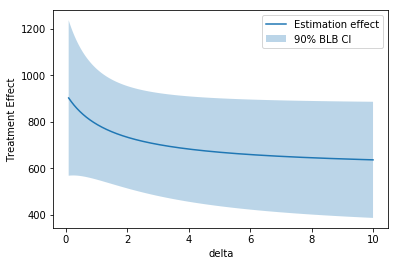

In [37]:
fig = plt.figure()
plt.plot(delta_seq, means_train, label='Estimation effect')
plt.fill_between(delta_seq, lowers_train, uppers_train, label="90% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("delta")
plt.legend()
plt.show()
fig.savefig(ecf.FIGURE_PATH + '/demand_train.png')
